In [1]:
%matplotlib inline

# Imports
import networkx as nx
import numpy
import matplotlib.pyplot as plt
import pandas

try:
    import seaborn; seaborn.set()
    
except ImportError:
    pass

# Import widget methods
from ipywidgets.widgets import *

# Graph Construction

We'll manually create a deterministic graph.

In [2]:
g = nx.Graph()
print((g.number_of_nodes(), g.number_of_edges()))

(0, 0)


In [4]:
g.add_node('alice')
print((g.number_of_nodes(), g.number_of_edges()))
g.add_node('bob')
print((g.number_of_nodes(), g.number_of_edges()))

(1, 0)
(2, 0)


In [8]:
# Add an edge between alice and bob
g.add_edge('alice', 'bob')

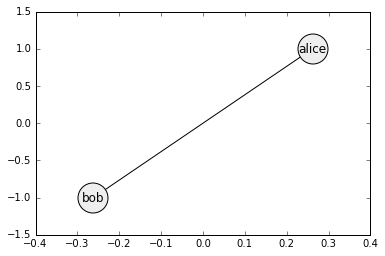

In [17]:
g_layout = nx.spring_layout(g, iterations=1000)
nx.draw_networkx(g, pos=g_layout, node_color='#eeeeee', node_size=900)

# Random Graph Construction

Next, we'll grow our own graph using the following procedure:

1. Each time step, sample a number of nodes to add.
2. For each node to add, sample a random set of edges to add.

**This formulation is a bit ambiguous.** For instance, regarding (2), what is the pool of potential edges from which we might draw? Is this pool updated each time step? This introduces questions of **time discretization** and **synchronicity.**

We seem to be implying that within each time step ($\Delta t$) we are only considering the nodes that currently exist (existed or were created at the end of the last time step).

In [97]:
# Create a new graph
g = nx.Graph()
num_steps = 10

# Iterate through time
for t in range(num_steps):
    # Draw a random number of nodes to add
    num_nodes_add = numpy.random.binomial(10, 0.1)
    num_edges_add = 0
        
    # Iterate through nodes to add; counting from last node ID
    for new_node_number in range(g.number_of_nodes(), g.number_of_nodes() + num_nodes_add):
        
        # Sample number of edges
        num_edges_per_node = numpy.random.binomial(g.number_of_nodes(), 0.3)
        num_edges_add += num_edges_per_node
                
        # New edges are determined randomly based on previously extant nodes
        nodes_to_connect = numpy.random.choice(list(range(g.number_of_nodes() + 1)), num_edges_per_node)

        #print('Current node: %d; New nodes to connect:' % new_node_number)
        #print(nodes_to_connect)
        # Don't allow self-connections; only connect nodes with fewer than three connections
        nodes_to_connect = [n for n in nodes_to_connect if n != new_node_number]
        nodes_to_connect = [n for n in nodes_to_connect if len(g.neighbors(n)) < 3]
        
        # Create edges to previously extant nodes
        g.add_edges_from([(new_node_number, x) for x in nodes_to_connect])
        
        g.add_node(new_node_number)
        
        print((g.number_of_nodes(), g.number_of_edges()))
        
# If any of the nodes are unconnected...
if 0 in map(len, [g.neighbors(n) for n in g.nodes()]):
    unconnected_nodes = [n for n in g.nodes() if len(g.neighbors(n)) == 0]
    
    for unconnected_node in unconnected_nodes:
        new_connection_num = numpy.random.choice([
                n for n in list(range(g.number_of_nodes())) if n not in unconnected_nodes
            ], 1)

        g.add_edges_from([(unconnected_node, x) for x in new_connection_num])
        

(1, 0)
(2, 0)
(3, 1)
(4, 2)
(5, 5)
(6, 5)
(7, 9)
(8, 9)
(9, 10)
(10, 12)


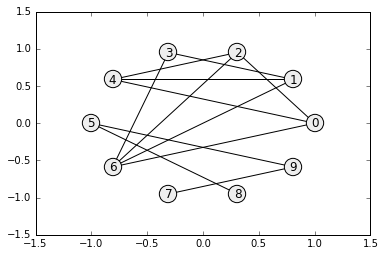

In [100]:
g_layout = nx.circular_layout(g)
nx.draw_networkx(g, pos=g_layout, node_color='#eeeeee')